In [81]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

src_file = './dest/id_wrf_narr_d01.nc'

ds = xr.open_dataset(src_file)

# Test coordinates are centered in Albertsons Stadium on Boise State's campus
lat = 43.603
lon = -116.196

In [17]:
da_xlatm = ds['XLAT_M']
da_xlongm = ds['XLONG_M']
da_xlatc = ds['XLAT_C']
da_xlongc = ds['XLONG_C']

ds_grid = da_xlatm.to_dataset()
ds_grid['XLONG_M'] = da_xlongm
ds_grid['XLAT_C'] = da_xlatc
ds_grid['XLONG_C'] = da_xlongc

In [18]:
ds_grid

<xarray.Dataset>
Dimensions:  (Time: 1, south_north: 289, west_east: 339, south_north_stag: 290, west_east_stag: 340)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag, west_east_stag
Data variables:
    XLAT_M   (Time, south_north, west_east) float32 ...
    XLONG_M  (Time, south_north, west_east) float32 ...
    XLAT_C   (Time, south_north_stag, west_east_stag) float32 ...
    XLONG_C  (Time, south_north_stag, west_east_stag) float32 ...

In [20]:
abslat = np.abs(ds_grid.XLAT_M - lat)
abslon = np.abs(ds_grid.XLONG_M - lon)
c = np.maximum(abslon, abslat)

In [38]:
([tloc],[yloc],[xloc]) = np.where(c == np.min(np.squeeze(c, axis=0)))

In [39]:
print(xloc)
print(yloc)

129
119


In [73]:
da_xlatm_test = ds_grid['XLAT_M'].sel(south_north=slice(yloc-5,yloc+5),west_east=slice(xloc-5,xloc+5))
da_xlongm_test = ds_grid['XLONG_M'].sel(south_north=slice(yloc-5,yloc+5),west_east=slice(xloc-5,xloc+5))
da_xlatc_test = ds_grid['XLAT_C'].sel(south_north_stag=slice(yloc-6,yloc+5),west_east_stag=slice(xloc-6,xloc+5))
da_xlongc_test = ds_grid['XLONG_C'].sel(south_north_stag=slice(yloc-6,yloc+5),west_east_stag=slice(xloc-6,xloc+5))



In [77]:
ds_grid_test = da_xlatm_test.to_dataset()
ds_grid_test['XLONG_M'] = da_xlongm_test
ds_grid_test['XLAT_C'] = da_xlatc_test
ds_grid_test['XLONG_C'] = da_xlongc_test
ds_grid_test

<xarray.Dataset>
Dimensions:  (Time: 1, south_north: 10, west_east: 10, south_north_stag: 11, west_east_stag: 11)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag, west_east_stag
Data variables:
    XLAT_M   (Time, south_north, west_east) float32 43.48 43.48 ... 43.72 43.73
    XLONG_M  (Time, south_north, west_east) float32 -116.4 -116.3 ... -116.0
    XLAT_C   (Time, south_north_stag, west_east_stag) float32 43.44 ... 43.71
    XLONG_C  (Time, south_north_stag, west_east_stag) float32 -116.4 ... -116.1

In [79]:
ds_grid_test.to_netcdf('./tests/testdest/testdestgrid.nc')

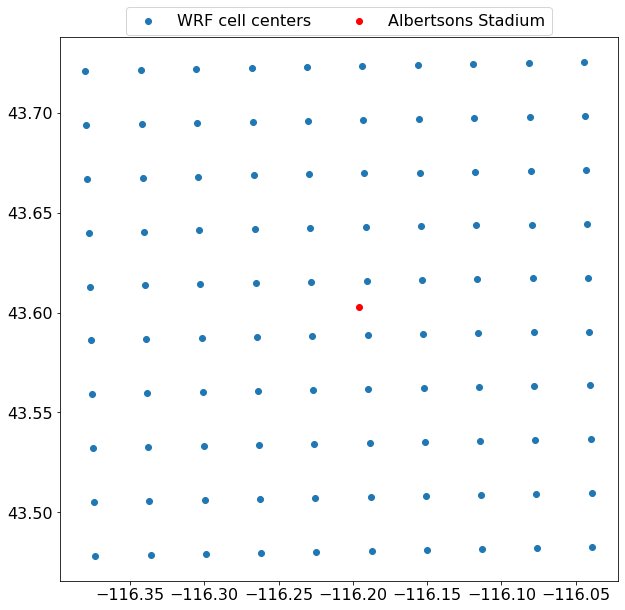

In [103]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
plt.scatter(ds_grid_test.XLONG_M.values,ds_grid_test.XLAT_M.values,label='WRF grid centers')
plt.scatter(lon,lat, color='r',label='Albertsons Stadium')
plt.legend(bbox_to_anchor=(0.5, 1.03), loc='center', ncol=2)
plt.show()
